In [3]:
#importing the libraries
import torch
import torch.nn as nn
from torch.nn import functional as  F

#setting the device
device="cuda" if torch.cuda.is_available() else "cpu"

#HYPER-PARAMETERS
block_size = 8
batch_size = 8
max_iters = 1000
learning_rate = 3e-3
eval_iters = 250
n_embed = 384
n_layers = 4
n_head = 4
dropout = 0.2

In [ ]:
with open("wizard_of_oz.txt", 'r', encoding="utf-8") as f:
    text=f.read()
vacab_size = len(chars)

In [ ]:
# to make sure pytorch does not use gradients for computation, this is done to reduce the computation time
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ["train","val"]:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y=get_batch(split)
            logits, loss=model(X,Y)
            losses[k]=loss.item()
        out[split]=losses.mean()
    model.train()
    return out

# artitecure defination

-- defining the multi head attention block
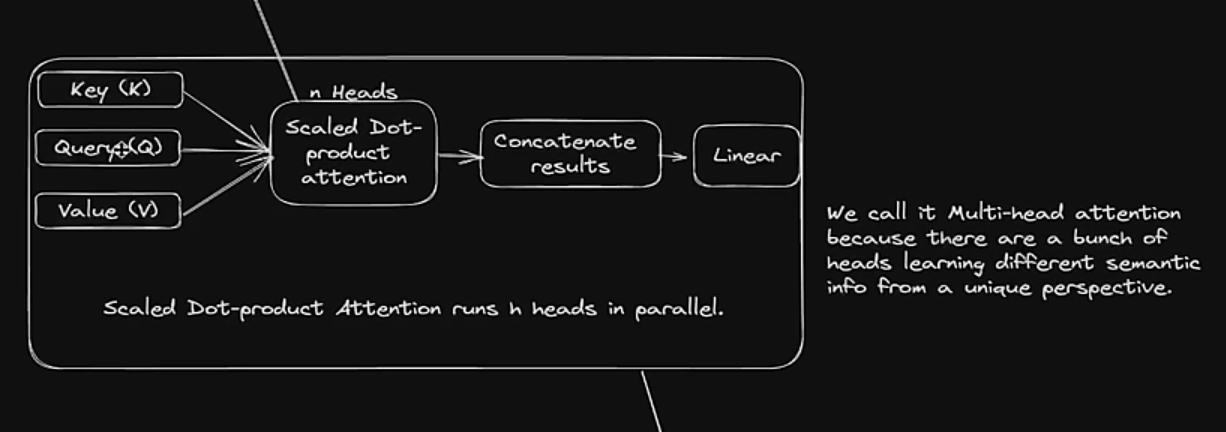

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.Module([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

defining the feeforward

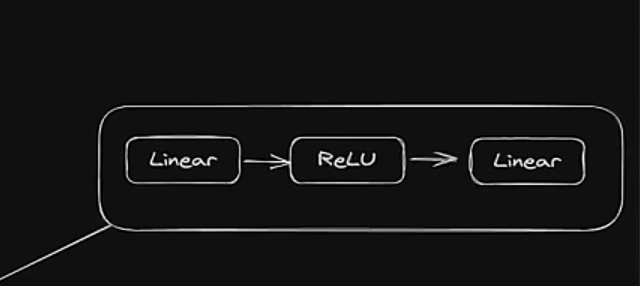

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

1) defing the block as below 
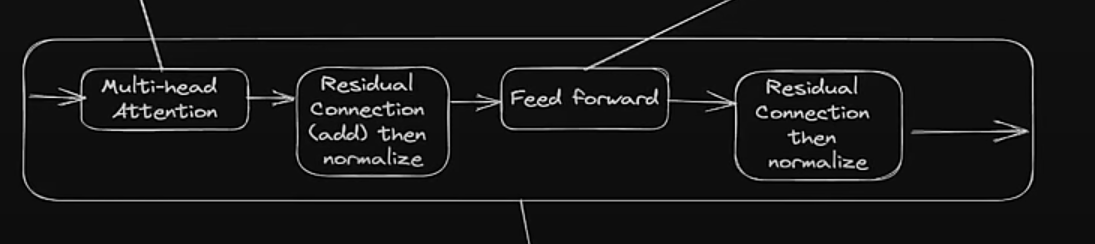

In [ ]:
#defining the decode block 
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        #n_embed is the embedding dimension, n_head is the number of head we,d like 
        super().__init__()
        head_size=n_embed // n_head  # head_size tell us how many features the each block in parallel will capture, n_head is the number of head we
        self.sa=MultiHeadAttention(n_head, head_size) #sa is the self attention     
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2=nn.LayerNorm(n_embed)

    #defing the forward propgation of the Block as described above
    def forward(self, x):
        #refer the image above for better understanding
        y = self.sa(x) #1) self attention
        x = self.ln1(x + y) #2) add and normalization
        y = self.ffwd(x) #3) feed forward
        x = self.ln2(x + y) #4) add and normalization
        return x







1) input and embeding with positionla embedding
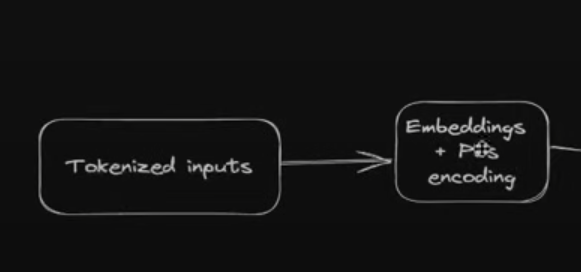

2) 4 decoder block
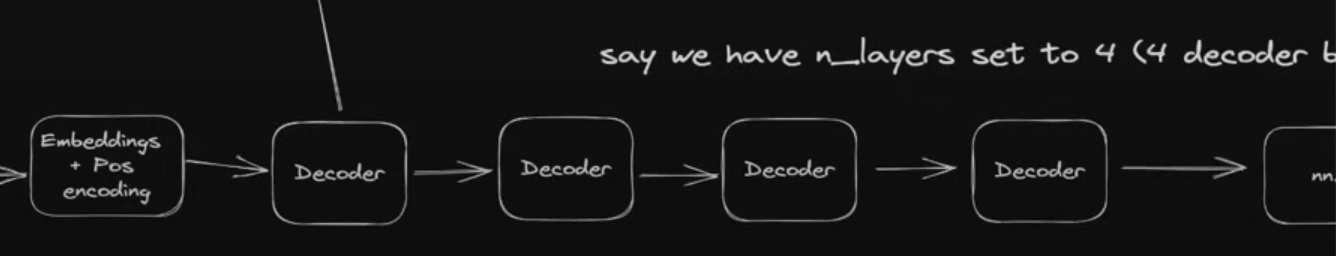

3) normalization layer

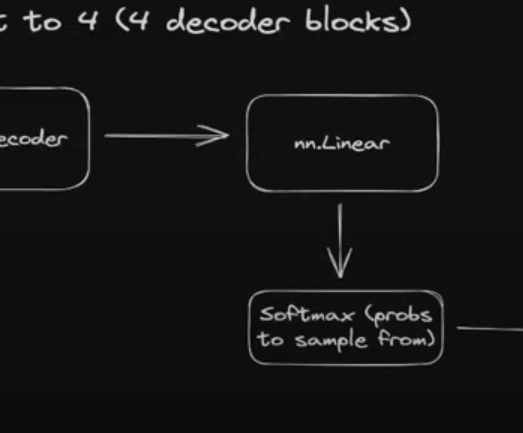

4)probablity distribution using softmax
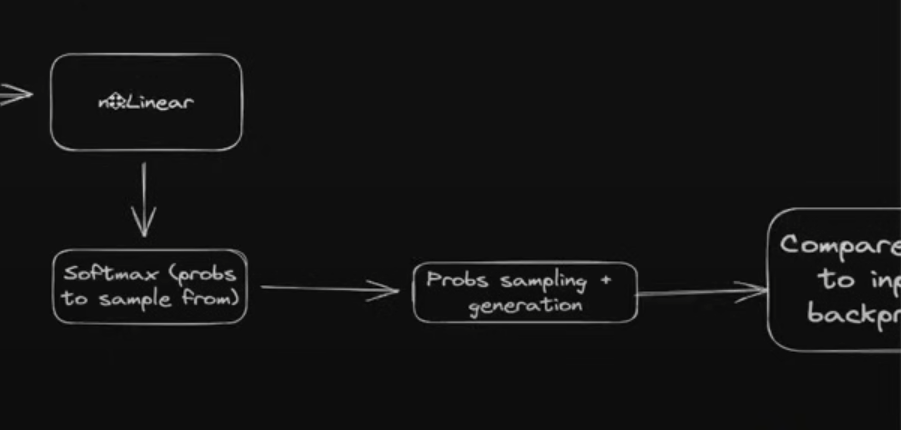

In [1]:


class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #defining an embedding vector based on the vacab_size
        self.token_embeddeing_table=nn.Embedding(vocab_size, n_embed)

        #defining the position embedding
        self.position_embeddeing_table=nn.Embedding(block_size, n_embed)

        #defining the decoder block 
        self.block = nn.Sequential(*[Block(n_embed, n_head=n_head) for _ in range(n_layers) ] ) #creating the four decoder layers using the Block class
        self.ln_f = nn.LayerNorm(n_embed ) # final layer normalization
        self.lm_head = nn.Linear(n_embed, vocab_size )  #to build probablity distribution on each vocab_size 

        self.apply(self.__init__weights)

    def __init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 )
            if model.bias is not None:
                torch.nn.init.zeros_(model.bias)
        elif isinstance(model, nn.Embedding):
            torch.nn.init.normal_(model.weight, mean=0.0, stf=0.02)
        

    """ 
    below fucntion is used to compute the forward pass of the model and 
    compute the loss for a particular 
    """
    def forward(self, index, targets=None):
        #accessing the embedding vector for a paticular index token 
        logits = self.token_embeddeing_table(index)


        #extra code for GPT
        # idx and target are both (batch, time ) tensor 
        token_embeddeing_table = self.token_embeddeing_table(idx) #(batch, time, channel) tensor
        position_embedding_table = self.position_embeddeing_table(torch.arange(Time, device=device)) # (time, channel ) shape
        x = token_embeddeing_table + position_embedding_table
        #feeding the toekn and position embedding to the sequential network
        x = self.block(x) # (batch, time, channel)
        #performing linear operation from the output of decoder block
        x = self.ln_f(x) #(batch, time, channel)
        #generating the probablity distribution
        logits = self.lm_head() # (batch, time, vocab_size)
        

        if targets is None:
            loss=None
        else:
            #we unpack the dimension using the .shape
            batch, time, channel=logits.shape
            #we pack the dimension using the .view, we flattenr the batch and time into single dimension to compute loss 
            logits=logits.view(batch*time, channel)
            # we flattern the target vector to get loss
            targets=targets.view(batch*time)
            loss=F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # the index form is (batch, time ) in refrance to the current context
        for _ in range(max_new_tokens):
            #getting the pridition 
            logits, loss=self.forward(index)
            
            #getting the last time step
            logits=logits[:, -1, :] # to make it (batch,  channel)

            #applying softmax to the probablity distribution
            prob=F.softmax(logits, dim=-1) 

            #getting a sample from the distribution
            index_next= torch.multinomial(prob, num_samples=1)

            #appending the generated token to the preexisiting data
            index=torch.cat((index, index_next), dim=-1)
        return index
    

model=GPT(vocab_size)
m=model.to(device)

context=torch.zeros((1,1), dtype=torch.long, device=device)
generated_characters=decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_characters)


IndentationError: expected an indented block (2291187564.py, line 22)